In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import math
from scipy.fft import fft, ifft, fftfreq
import scipy.signal as sg
from scipy.stats import norm, shapiro, kstest
from scipy import interpolate
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from fbprophet import Prophet
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pywt
import pywt.data
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
import seaborn as sns
from datetime import date, datetime
plt.style.use("seaborn")
sns.set(style="white")

## Lectura y exploración

In [2]:
df_raw = pd.read_csv("./data/delitos_2016-2019.csv")
df_raw['fecha'] = pd.to_datetime(df_raw.fecha, format='%Y-%m-%d')
df_raw["anio"]=df_raw.fecha.dt.year
df_raw["mes"]=df_raw.fecha.dt.month
df_raw["periodo"]=df_raw.anio.apply(str) + '-' + df_raw.mes.apply(lambda l: str(l).rjust(2, '0'))
df_raw.head()

dates_columns = ['holidays_2016', 'holidays_2017', 'holidays_2018', 'holidays_2019',
                 'holidays_winter_2016', 'holidays_winter_2017', 'holidays_winter_2018', 'holidays_winter_2019']
df_holidays = pd.read_csv("./data/holidays.csv", parse_dates=dates_columns)

In [ ]:
df_raw.profile_report()

## FIltrado

In [3]:
df_raw.groupby(['tipo_delito']).agg('count').reset_index()[['tipo_delito', 'id']].rename(columns={'id': 'cantidad'})

,tipo_delito,cantidad
0,Homicidio,1018
1,Hurto (sin violencia),179873
2,Lesiones,34210
3,Robo (con violencia),273440


In [4]:
df_filter = df_raw[df_raw.tipo_delito == 'Robo (con violencia)']
#df_filter = df_raw.copy()

## Agrupación

In [5]:
df_group = df_filter[['fecha','cantidad_registrada']].groupby(['fecha']).agg("sum").reset_index()
df_group["anio"]=df_group.fecha.dt.year
df_group["mes"]=df_group.fecha.dt.month
df_group["periodo"]=df_group.anio.apply(str) + '-' + df_group.mes.apply(lambda l: str(l).rjust(2, '0'))
df_group = df_group.set_index('fecha')

display(df_group.groupby(['anio']).agg('count').reset_index()[['anio', 'mes']].rename(columns={'mes': 'cantidad_por_anio'}))
days_by_year = df_group[['anio', 'mes']].rename(columns={'mes': 'cantidad'}).groupby(['anio']).agg('count').reset_index()

,anio,cantidad_por_anio
0,2016,366
1,2017,365
2,2018,365
3,2019,365


In [6]:
df_group['dia_semana'] = df_group.index
#df_group.dia_semana = df_group.dia_semana.apply(lambda d: d.strftime('%A'))
df_group.dia_semana = df_group.dia_semana.apply(lambda d: d.weekday())
df_count_by_week_day = df_group.groupby(['dia_semana']).agg('sum').reset_index()[['dia_semana', 'cantidad_registrada']].rename(columns={'cantidad_registrada': 'cantidad'})
df_count_by_week_day.head(7)

,dia_semana,cantidad
0,0,41810.0
1,1,40571.0
2,2,41102.0
3,3,40416.0
4,4,41626.0
5,5,36818.0
6,6,31097.0


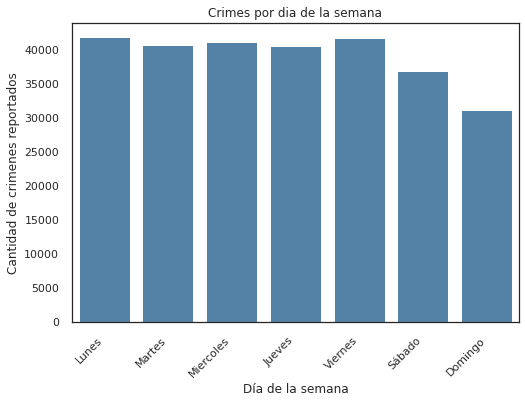

In [7]:
ax = sns.barplot(df_count_by_week_day.dia_semana, df_count_by_week_day.cantidad, color='steelblue')
ax.set(xlabel='Día de la semana', ylabel='Cantidad de crimenes reportados')
ax.set_title("Crimes por dia de la semana")
ax.set_xticklabels(['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'], rotation=45, horizontalalignment='right')
plt.show()

In [8]:
def plot_by_year(series, holidays, winter_holidays, year, axs, max_value, min_value):
    total = len(series)
    ticks = [x*period for x in range(int(total/period))] + [total - 1]
    labels = [np.datetime_as_string(series.index.values[i], unit='h') for i in ticks]

    axs.plot(np.arange(total), series, '-', label='Cantidad registrada', color='k')
    axs.vlines(winter_holidays, min_value, max_value, alpha=0.5, color ='darkblue', label='Vacaciones de invierno')
    axs.vlines(holidays, min_value, max_value, alpha=0.5, color ='orangered', label='Feriados')
    axs.set_title(f'{year}')
    #axs.set_ylabel('Cantidad')
    axs.set_xticks(ticks)
    axs.set_xticklabels(labels)
    return axs

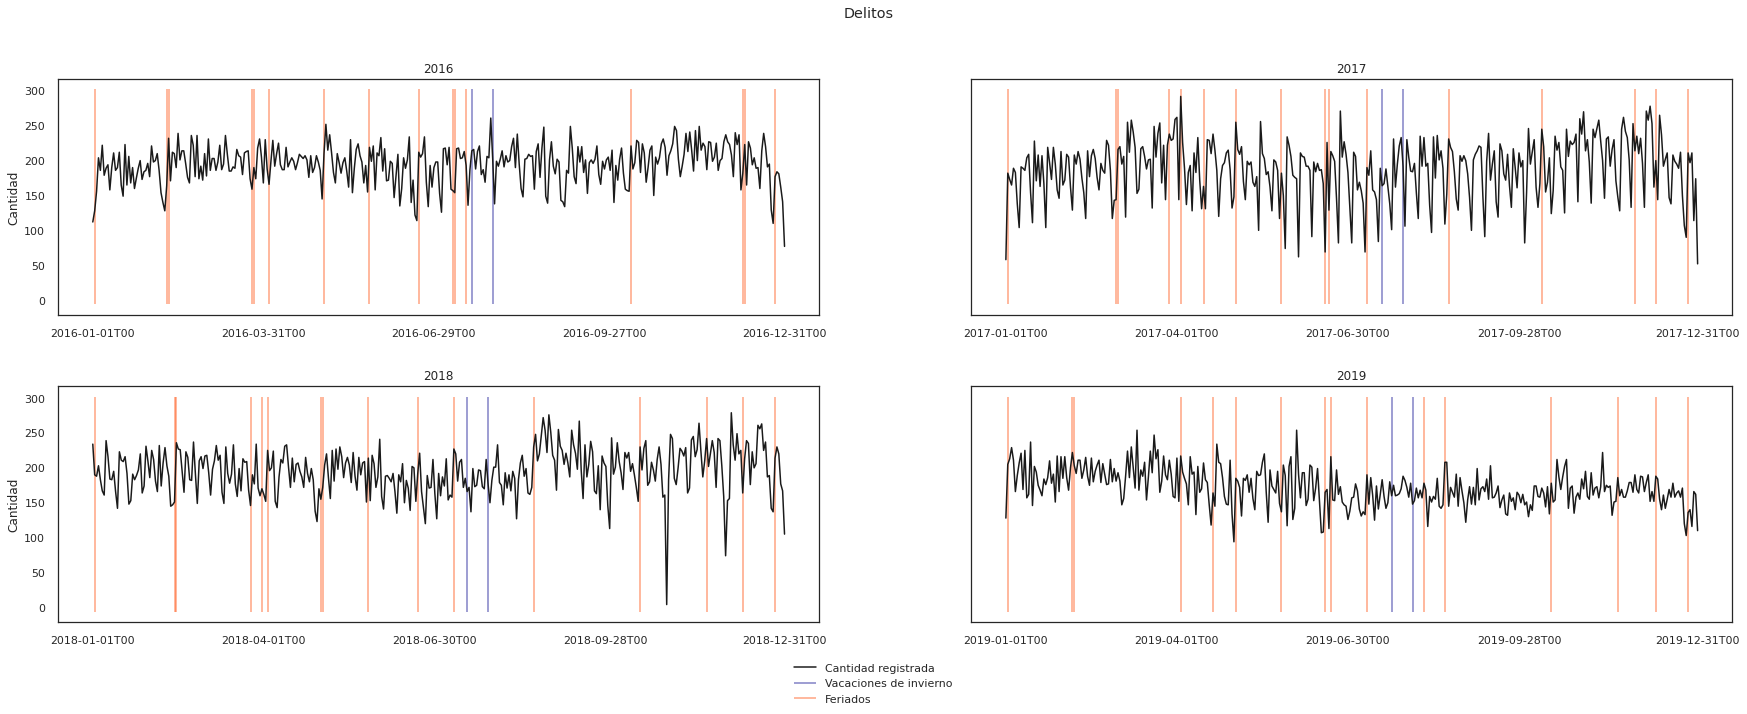

In [9]:
period = 90
max_value = df_group.cantidad_registrada.max() + 10
min_value = df_group.cantidad_registrada.min() - 10
fig, axs = plt.subplots(2, 2, figsize=(30, 10), sharey=True, gridspec_kw={'hspace': 0.3})
axs[0, 0] = plot_by_year(df_group[df_group.anio==2016].cantidad_registrada, df_holidays.dnh_2016.dropna(), df_holidays.dnhw_2016.dropna(), 2016, axs[0, 0], max_value, min_value)
axs[0, 1] = plot_by_year(df_group[df_group.anio==2017].cantidad_registrada, df_holidays.dnh_2017.dropna(), df_holidays.dnhw_2017.dropna(), 2017, axs[0, 1], max_value, min_value)
axs[1, 0] = plot_by_year(df_group[df_group.anio==2018].cantidad_registrada, df_holidays.dnh_2018.dropna(), df_holidays.dnhw_2018.dropna(), 2018, axs[1, 0], max_value, min_value)
axs[1, 1] = plot_by_year(df_group[df_group.anio==2019].cantidad_registrada, df_holidays.dnh_2019.dropna(), df_holidays.dnhw_2019.dropna(), 2019, axs[1, 1], max_value, min_value)
axs[0, 0].set_ylabel('Cantidad')
axs[1, 0].set_ylabel('Cantidad')

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'lower center')
fig.suptitle("Delitos")
plt.show()

## Normalidad

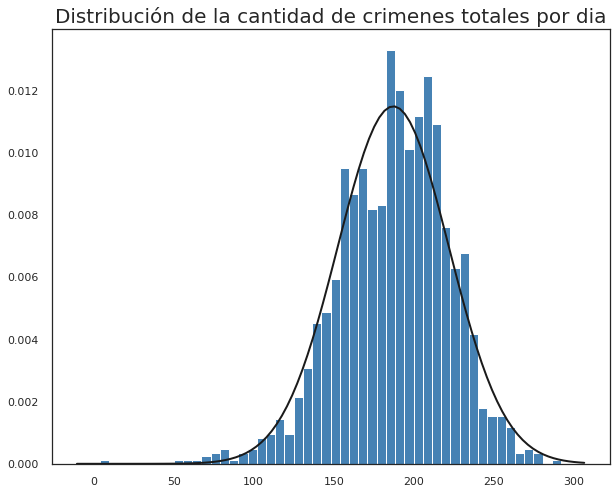

In [10]:
plt.figure(figsize=(10,8))
plt.hist(df_group.cantidad_registrada, density=True, bins=50, color='steelblue')
plt.title("Distribución de la cantidad de crimenes totales por dia", fontsize = 20)

mu, std = norm.fit(df_group.cantidad_registrada)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [11]:
(_,p) = shapiro(df_group.cantidad_registrada)
print(f'p-value para Shapiro test es de {p}')

p-value para Shapiro test es de 1.192303145103324e-09


In [12]:
(_,p) = kstest(df_group.cantidad_registrada, 'norm')
print(f'p-value para Kolmogorow test es de {p}')

p-value para Kolmogorow test es de 0.0


## Tests
Solo con la serie hasta 2018

In [13]:
def print_dicky_fuller_test(timeseries, cutoff=0.05):
    fuller_test = adfuller(timeseries, autolag='AIC', maxlag=28 )
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in fuller_test[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    pvalue = fuller_test[1]
    if pvalue < cutoff:
        print(f'p-value = {pvalue:.4f}. The series is likely stationary.')
    else:
        print(f'p-value = {pvalue:.4f}. The series is likely non-stationary.')
    
    print(dfoutput)

In [14]:
def print_kpss_test(timeseries, cutoff=0.05):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags=28)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    pvalue = kpss_output[1]
    if pvalue > cutoff:
        print(f'p-value = {pvalue:.4f}. The series is likely stationary.')
    else:
        print(f'p-value = {pvalue:.4f}. The series is likely non-stationary.')
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [15]:
print_dicky_fuller_test(df_group[df_group.anio < 2019].cantidad_registrada)

Results of Dickey-Fuller Test:
p-value = 0.0004. The series is likely stationary.
Test Statistic                   -4.324038
p-value                           0.000404
#Lags Used                       28.000000
Number of Observations Used    1067.000000
Critical Value (1%)              -3.436493
Critical Value (5%)              -2.864253
Critical Value (10%)             -2.568214
dtype: float64


In [16]:
print_kpss_test(df_group[df_group.anio < 2019].cantidad_registrada)

Results of KPSS Test:
p-value = 0.1000. The series is likely stationary.
Test Statistic            0.147442
p-value                   0.100000
#Lags Used               28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
/home/zero/Apps/miniconda3/envs/datascience/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [17]:
# Si no fuese estacionaria se aplica la funcion diff y se vuelven a correr los tests
#cantidad_diff = diff(df_group.cantidad_registrada)
#print_dicky_fuller_test(cantidad_diff)
#print_kpss_test(cantidad_diff)

## Descomposición estacionaria

In [18]:
seasonal = sm.tsa.seasonal_decompose(df_group[df_group.anio < 2019].cantidad_registrada, model='additive', freq=7)

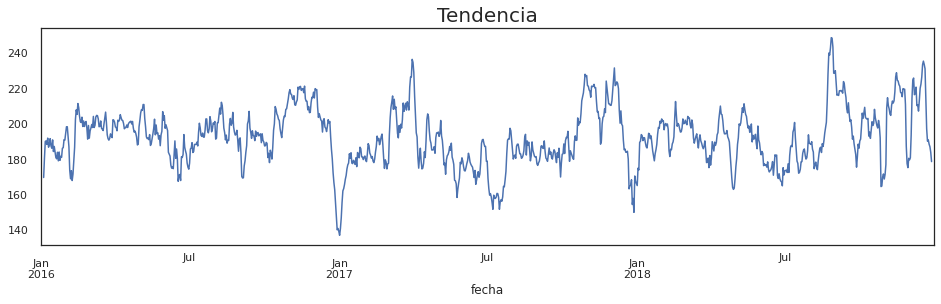

In [19]:
fig = plt.figure(figsize=(16,4))
plt.title("Tendencia", fontsize = 20)
seasonal.trend.plot()
#f.set_size_inches(16, 16)
plt.show()

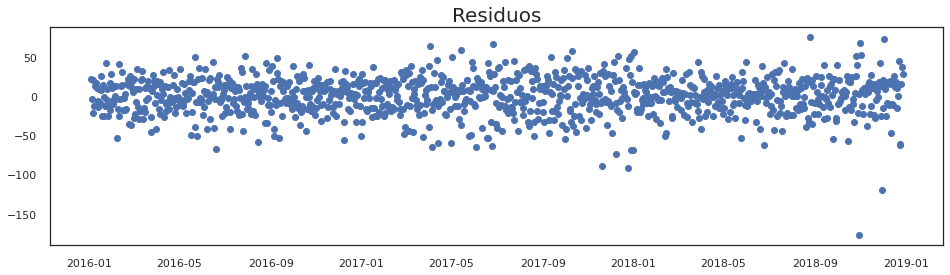

In [20]:
fig = plt.figure(figsize=(16,4))
plt.title("Residuos", fontsize = 20)
plt.scatter(seasonal.resid.index, seasonal.resid)
plt.show()

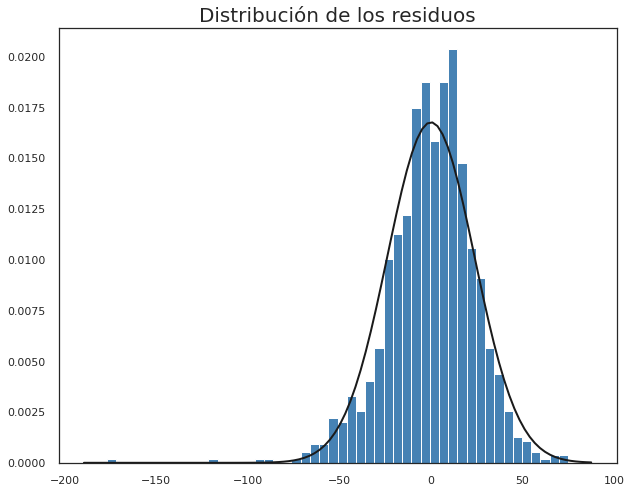

In [21]:
plt.figure(figsize=(10,8))
plt.hist(seasonal.resid, density=True, bins=50, color='steelblue')
plt.title("Distribución de los residuos", fontsize = 20)

mu, std = norm.fit(seasonal.resid.dropna())

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.show()

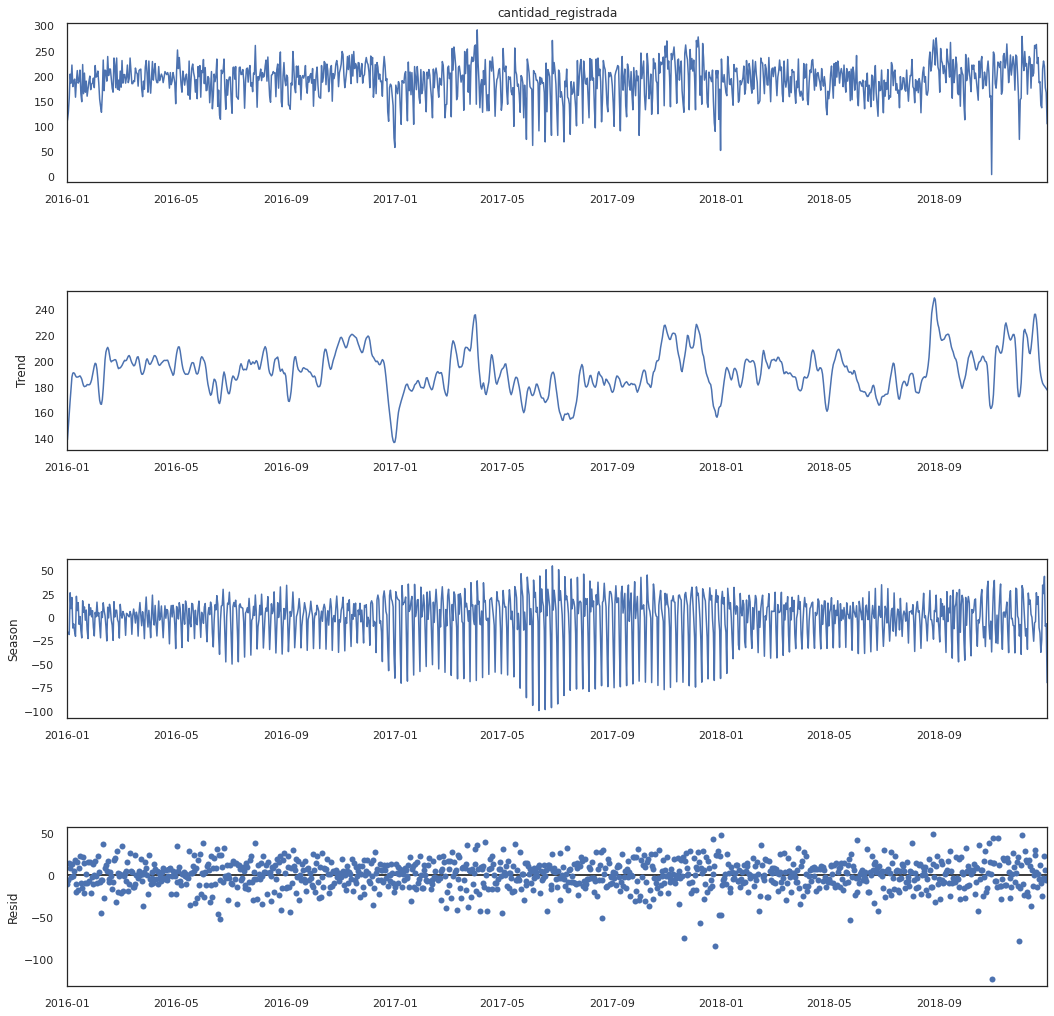

In [22]:
stl = STL(df_group[df_group.anio < 2019].cantidad_registrada)
res = stl.fit()
f = fig = res.plot()
f.set_size_inches(16, 16)

## Prophet

In [25]:
train = df_group[df_group.anio <= 2018] # entreno con la serie hasta 2018
test = df_group[df_group.anio == 2019]
train = train.reset_index()[['fecha', 'cantidad_registrada']].rename(columns={'fecha': 'ds', 'cantidad_registrada': 'y'})
test = test.reset_index()[['fecha', 'cantidad_registrada']].rename(columns={'fecha': 'ds', 'cantidad_registrada': 'y'})
display(train.tail(3))
display(test.tail(3))

,ds,y
1093,2018-12-29,177.0
1094,2018-12-30,167.0
1095,2018-12-31,105.0


,ds,y
362,2019-12-29,166.0
363,2019-12-30,162.0
364,2019-12-31,110.0


In [26]:
holidays = pd.DataFrame({
  'holiday': 'feriados_nacionales',
  'ds': pd.concat([df_holidays.holidays_2016, df_holidays.holidays_2017, df_holidays.holidays_2018, df_holidays.holidays_2019]),
  'lower_window': 0,
  'upper_window': 1,
})

In [49]:
prophet_basic = Prophet(interval_width=0.85, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False,
                        seasonality_mode='additive')
prophet_basic.add_country_holidays("AR")
prophet_basic.add_seasonality(name='days', period=6.9, fourier_order=1)
#prophet_basic.add_seasonality(name='weeks', period=2.3, fourier_order=2)
#prophet_basic.add_seasonality(name='weeks', period=3.5, fourier_order=2)
prophet_basic.add_seasonality(name='weeks', period=7, fourier_order=3)
prophet_basic.add_seasonality(name='month', period=30, fourier_order=5)
prophet_basic.add_seasonality(name='three_month', period=90, fourier_order=10)
prophet_basic.add_seasonality(name='six_months', period=180, fourier_order=30)
prophet_basic.add_seasonality(name='year', period=365, fourier_order=50)

prophet_basic.fit(train)
predictions = prophet_basic.make_future_dataframe(365, 'd')
predictions = prophet_basic.predict(predictions)
predictions.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Año Nuevo [New Year's Day],Año Nuevo [New Year's Day]_lower,Año Nuevo [New Year's Day]_upper,Día Nacional de la Memoria por la Verdad y la Justicia [Memory's National Day for the Truth and Justice],...,weeks,weeks_lower,weeks_upper,year,year_lower,year_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1456,2019-12-27,208.983122,180.050802,245.551691,206.787041,211.140969,0.0,0.0,0.0,0.0,...,12.331360,12.331360,12.331360,3.346672,3.346672,3.346672,0.0,0.0,0.0,213.520942
1457,2019-12-28,209.006667,157.228530,223.069499,206.804422,211.179453,0.0,0.0,0.0,0.0,...,-12.985343,-12.985343,-12.985343,-6.148306,-6.148306,-6.148306,0.0,0.0,0.0,191.029560
1458,2019-12-29,209.030212,114.054357,179.616964,206.819137,211.215650,0.0,0.0,0.0,0.0,...,-46.928572,-46.928572,-46.928572,-20.984693,-20.984693,-20.984693,0.0,0.0,0.0,146.934764
1459,2019-12-30,209.053757,154.656100,219.262183,206.833531,211.248328,0.0,0.0,0.0,0.0,...,13.610255,13.610255,13.610255,-35.112596,-35.112596,-35.112596,0.0,0.0,0.0,187.003870
1460,2019-12-31,209.077302,132.369196,199.254999,206.847924,211.280551,0.0,0.0,0.0,0.0,...,11.034472,11.034472,11.034472,-42.304825,-42.304825,-42.304825,0.0,0.0,0.0,165.026839


In [50]:
results = pd.DataFrame({'ds': test.ds, 'y': test.y})
results = pd.merge(results, predictions[["ds", "yhat", 'yhat_lower', 'yhat_upper']], on = ["ds"], how='inner')[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']]
results = results.set_index('ds')
results.head(3)

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2019-01-01,128.0,161.670869,129.299834,193.746605
2019-01-02,205.0,180.579358,146.979178,211.637592
2019-01-03,213.0,199.832675,166.525457,232.348536


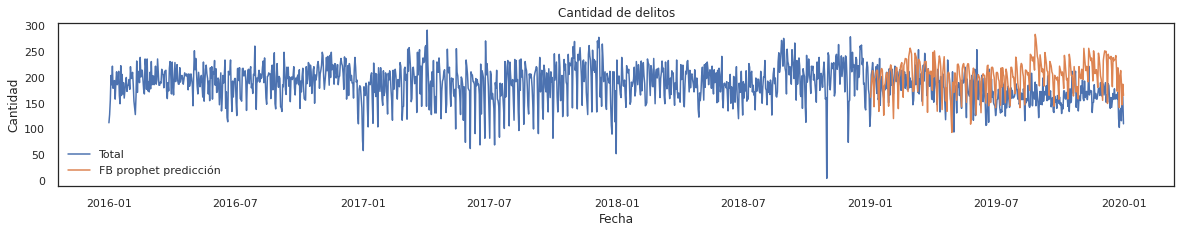

In [51]:
plt.figure(figsize = [20,3])
plt.plot(df_group.cantidad_registrada, label="Total")
plt.plot(results.yhat, label="FB prophet predicción")
plt.title("Cantidad de delitos")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.legend()
plt.show()

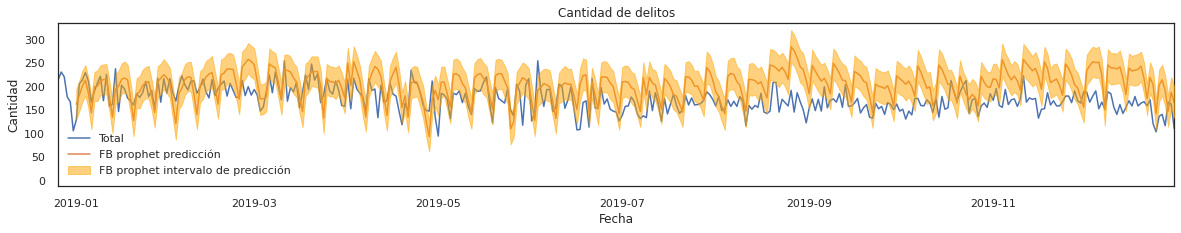

In [52]:
f, ax = plt.subplots(figsize=(20, 3))
plt.plot(df_group.cantidad_registrada, label="Total", zorder = 1)
plt.plot(results.yhat, label="FB prophet predicción", zorder = 2)
plt.fill_between(results.index, results.yhat_lower.values, results.yhat_upper.values, alpha=0.5, color ="orange", label="FB prophet intervalo de predicción", zorder = 3)
plt.title("Cantidad de delitos")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
ax.set_xlim(df_group.index[1090], df_group.index[-1])
plt.legend()
plt.show()

In [53]:
print(mean_squared_error(results.y, results.yhat))

2035.1427038995284


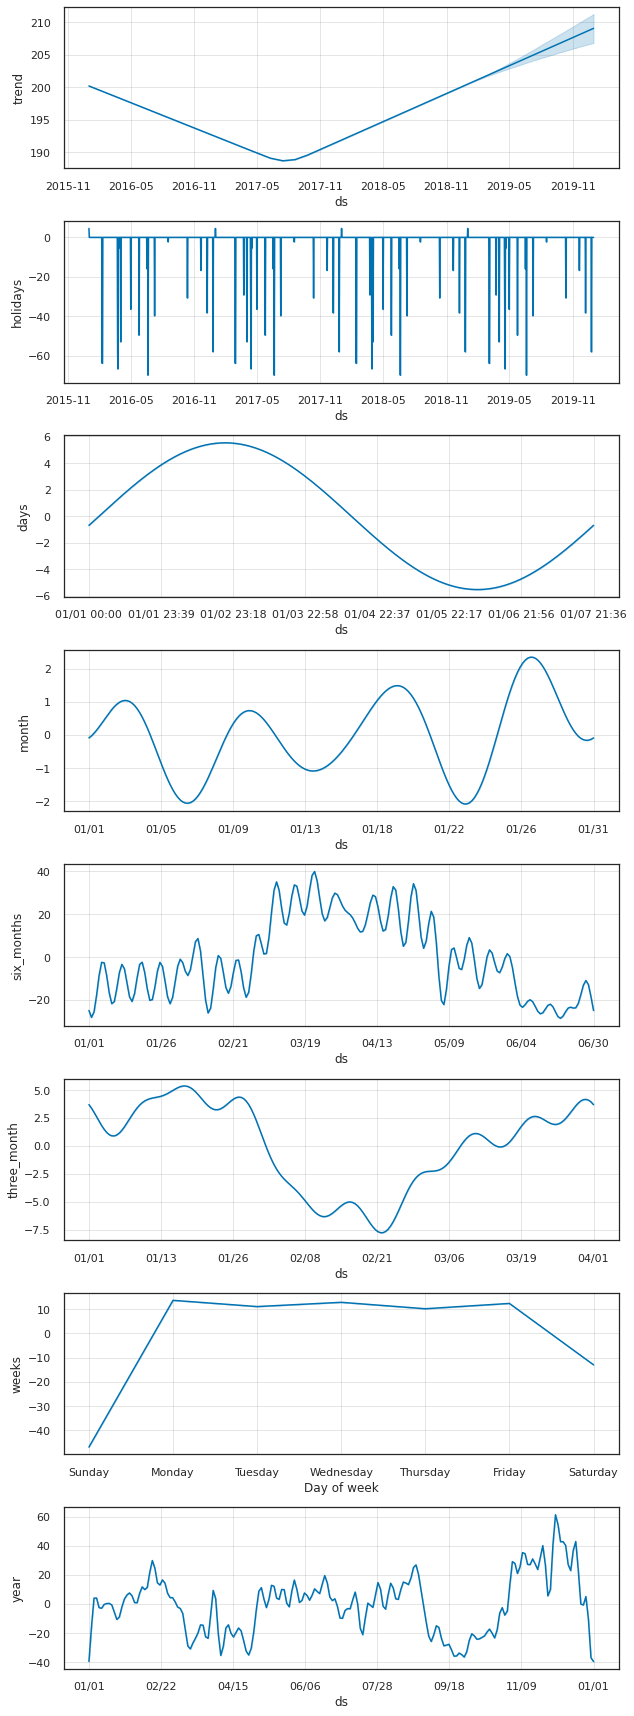

In [54]:
prophet_basic.plot_components(predictions)
plt.show()

## Fourier

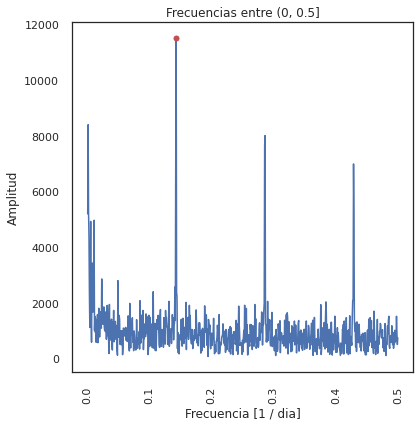

In [23]:
fft_output = fft(df_group.cantidad_registrada.values)
power = np.abs(fft_output)
freq = fftfreq(len(df_group.cantidad_registrada.values))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

fig, ax = plt.subplots( figsize=(6, 6) )

#ax1 = plt.subplot( 1, 2, 1 )
#ax1.plot(freq, power, label='signal')
#ax1.set_title('Todas las frecuencias')
#ax1.set_ylabel( 'Amplitud' )
#ax1.set_xlabel( 'Frecuencia [1 / dia]' )
#plt.xticks(rotation=90)

#ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.5)
ax.plot(freq[mask], power[mask])
ax.set_title('Frecuencias entre (0, 0.5]')
ax.set_ylabel( 'Amplitud' )
ax.set_xlabel( 'Frecuencia [1 / dia]' )

peaks = sg.find_peaks(power[freq >=0], prominence=10**4)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [24]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/day)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)
output

,index,freq (1/day),amplitude,period (days),fft
0,209,0.143053,11510.279507,6.990431,7782.498077+8480.522272j


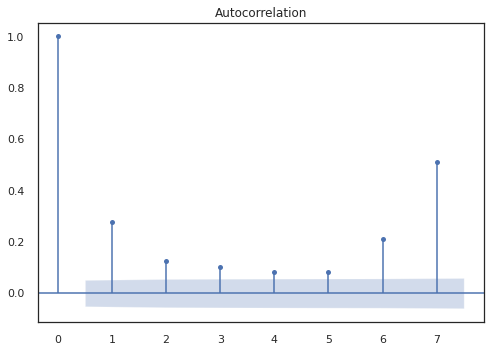

In [55]:
fig = plot_acf(df_group.cantidad_registrada.values, lags=7)

## Redes Neuronales

In [ ]:
train_torch = df_group[df_group.anio <= 2018].cantidad_registrada.values.astype(float)
test_torch = df_group[df_group.anio == 2019].cantidad_registrada.values.astype(float)

sc = MinMaxScaler(feature_range=(-1, 1))
train_norm = sc.fit_transform(train_torch .reshape(-1, 1))
train_norm = torch.FloatTensor(train_norm).view(-1)

test_norm = sc.transform(test_torch.reshape(-1, 1))
test_norm = torch.FloatTensor(test_norm).view(-1)

In [ ]:
def create_input_output(input_data, window, ndays = 1):
    input_output = []
    data_size = len(input_data)
    for i in range(data_size - window - ndays):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window+ndays:i+window+ndays+1]
        input_output.append((train_seq ,train_label))
    return input_output

## LSTM

In [ ]:
ndays = 5
window = 30
train_input_output = create_input_output(train_norm, window, ndays)
test_input_output = create_input_output(test_norm, window, ndays)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
model = LSTM()
loss_function = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 100

for i in range(epochs):
    for inputs, labels in train_input_output:
        optimizer.zero_grad()

        y_pred = model(inputs)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
y_pred_norm = []
for inputs, labels in test_input_output:
    with torch.no_grad():
        y_pred_norm.append(model(inputs).item())
y_pred_norm[:5]

In [ ]:
y_pred = pd.DataFrame({'fecha': df_group[df_group.anio == 2019].index[window+ndays:],
                        'y': sc.inverse_transform(np.array(y_pred_norm).reshape(-1, 1))[:,-1]
                    })
y_pred = y_pred.set_index('fecha')
y_pred.head(3)

In [ ]:
plt.figure(figsize = [20,5])
plt.plot(df_group.cantidad_registrada, label="Total")
plt.plot(y_pred.y, label="LSTM predicción")
plt.title("Cantidad de delitos")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.legend()
plt.show()

In [ ]:
mean_squared_error(test_torch[window+ndays:], y_pred.y)

## CNN

In [ ]:
ndays = 10
window = 30
train_input_output = create_input_output(train_norm, window, ndays)
test_input_output = create_input_output(test_norm, window, ndays)

In [ ]:
# Documentation of pytorch Conv1D: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
class NN_conv(nn.Module):
    def __init__(self):
        super(NN_conv, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv1d(
                in_channels=1,             # Number of channels in the input image
                out_channels=5,            # Number of channels produced by the convolution
                kernel_size=5,             # Size of the convolving kernel 
                stride=1,                  # Stride of the convolution. Default: 1 
                padding=2,                 # Zero-padding added to both sides of the input. Default: 0 
            ),                              
            nn.ReLU(),                      
            nn.MaxPool1d(kernel_size=3),
        )
        self.conv2 = nn.Sequential(         
            nn.Conv1d(
                in_channels=5,             
                out_channels=8,             
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool1d(kernel_size=2),    
            
        )
        self.out = nn.Linear(40, 1)  #output 3 classes: Cargo, Passenger or Fishing


    def forward(self, x):
        #print(x.size())
        x = self.conv1(x)
        #print(x.size())
        x = self.conv2(x)
        #print(x.size())
        x = x.view(-1, 8 * 5)
        #print(x.size())
        output = self.out(x)
        return output


net = NN_conv()

In [ ]:
model = NN_conv()
loss_function = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
epochs = 100

for i in range(epochs):
    for inputs, labels in train_input_output:
        optimizer.zero_grad()
        inputs = inputs.view(1,1,window) # (N,C,L) N is a batch size, C denotes a number of channels, L is a length of signal sequence. https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        y_pred = model(inputs)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
y_pred_norm = []
for inputs, labels in test_input_output:
    with torch.no_grad():
        inputs = inputs.view(1,1,window)
        y_pred_norm.append(model(inputs).item())

In [ ]:
y_pred = pd.DataFrame({'fecha': df_group[df_group.anio == 2019].index[window+ndays:],
                        'y': sc.inverse_transform(np.array(y_pred_norm).reshape(-1, 1))[:,-1]
                    })
y_pred = y_pred.set_index('fecha')
y_pred.head(3)

In [ ]:
plt.figure(figsize = [20,5])
plt.plot(df_group.cantidad_registrada, label="Total")
plt.plot(y_pred.y, label="CNN predicción")
plt.title("Cantidad de delitos")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.legend()
plt.show()

In [ ]:
mean_squared_error(test_torch[window+ndays:], y_pred.y)

## Medias móviles

In [ ]:
df_rollings = pd.DataFrame({
    'ma1': df_group.cantidad_registrada.rolling(window=1, center=True, min_periods=1).mean(),
    'ma7': df_group.cantidad_registrada.rolling(window=7, center=True, min_periods=4).mean(),
    'ma15': df_group.cantidad_registrada.rolling(window=15, center=True, min_periods=8).mean(),
    'ma30': df_group.cantidad_registrada.rolling(window=30, center=True, min_periods=15).mean()
}, index=df_group.index)

f, ax = plt.subplots(figsize=(16, 4))
ax.set_xlabel('Fecha')
ax.set_ylabel('Cantidad')
ax.set_title('Delitos')
period = 90
total = len(df_rollings.ma1)
ticks = [x*period for x in range(int(total/period))]
labels = [np.datetime_as_string(df_rollings.index.values[i], unit='h') for i in ticks]
xticks(ticks, labels, rotation=45)
plt.plot(np.arange(total), df_rollings.ma7, '-', label='ma7')
plt.plot(np.arange(total), df_rollings.ma15, '-', label='ma15')
plt.plot(np.arange(total), df_rollings.ma30, '-', label='ma30')
ax.legend()
plt.show()

In [ ]:
df_fft = pd.DataFrame({
    #'cantidad_registrada': group.cantidad_registrada,
    #'cantidad_registrada': np.abs(fft(group.cantidad_registrada.values)),
    'lfilter': sg.lfilter([1/3, 1/3, 1/3], 1.0, list(df_group.cantidad_registrada)[-2:] + list(df_group.cantidad_registrada))[2:],
    'filter_ma3': df_group.cantidad_registrada.rolling(window=3,center=True,min_periods=2).mean()
}, index=df_group.index)

f, ax = plt.subplots(figsize=(16, 4))
sns.lineplot(x=list(df_fft.index)*2, y="value", hue='variable', data=pd.melt(df_fft))
plt.show()

## Mensual

In [ ]:
df_group_mensual = df_raw[['periodo','cantidad_registrada']].groupby(['periodo']).agg("sum").reset_index()
df_group_mensual.index = pd.to_datetime(df_group_mensual.periodo, format='%Y-%m-%d')
del df_group_mensual['periodo']
df_group_mensual.head(3)

In [ ]:
seasonal = sm.tsa.seasonal_decompose(df_group_mensual.cantidad_registrada, model='additive')
f = seasonal.plot()
f.set_size_inches(16, 16)
plt.show()

In [ ]:
df_raw.tipo_delito.unique()

In [ ]:
df_raw[df_raw.tipo_delito=='Hurto (sin violencia)']